In [23]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import random

chapter = "chapter2_rl"
repo = "ARENA_3.0"

if IN_COLAB:
    if not os.path.exists("chapter2_rl"):
        !pip install wandb==0.13.10 einops gym==0.23.1 pygame jaxtyping

        os.system(f"wget https://github.com/callummcdougall/{repo}/archive/refs/heads/main.zip")
        os.system(f"unzip /content/main.zip '{repo}-main/{chapter}/exercises/*'")
        sys.path.append(f"/content/{repo}-main/{chapter}/exercises")

else:
    raise Exception("Se estiver rodando no VSCode, copie o código da página do Streamlit, não do Colab.")

from dataclasses import dataclass
import gym
import gym.spaces
import gym.envs.registration
import plotly.express as px
import plotly.graph_objects as go
from tqdm import trange
import torch as t
from torch import nn, Tensor
import wandb
from jaxtyping import Float, Int, Bool
from IPython.display import clear_output
import warnings

warnings.filterwarnings('ignore')

Arr = np.ndarray
ObsType = int
ActType = int

device = t.device("cuda" if t.cuda.is_available() else "cpu")

class DiscreteEnviroGym(gym.Env):
    action_space: gym.spaces.Discrete
    observation_space: gym.spaces.Discrete

    def __init__(self, env):
        super().__init__()
        self.env = env
        self.observation_space = gym.spaces.Discrete(env.num_states)
        self.action_space = gym.spaces.Discrete(env.num_actions)
        self.reset()

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        (states, rewards, probs) = self.env.dynamics(self.pos, action)
        idx = self.np_random.choice(len(states), p=probs)
        (new_state, reward) = (states[idx], rewards[idx])
        self.pos = new_state
        done = self.pos in self.env.terminal
        return (new_state, reward, done, {"env": self.env})

    def reset(self, seed: int | None = None, options=None) -> ObsType:
        super().reset(seed=seed)
        self.pos = self.env.start
        return self.pos

    def render(self, mode="human"):
        assert mode == "human", f"Mode {mode} não suportado!"

In [24]:
import pandas as pd
import numpy as np
import os

def introduce_missingness(dataframe, missing_fraction=0.1, random_state=42):
    """
    Introduz valores faltantes aleatoriamente no DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): O DataFrame original.
    - missing_fraction (float): Fração de valores a serem tornados faltantes.
    - random_state (int): Semente para reprodutibilidade.

    Returns:
    - pd.DataFrame: O DataFrame com valores faltantes introduzidos.
    """
    np.random.seed(random_state)
    dataframe = dataframe.copy()
    n_rows, n_cols = dataframe.shape
    n_missing = int(np.floor(missing_fraction * n_rows * n_cols))

    for _ in range(n_missing):
        i = np.random.randint(0, n_rows)
        j = np.random.randint(0, n_cols)
        dataframe.iat[i, j] = np.nan

    return dataframe

file_path = "/content/data_personality.csv"

if not os.path.isfile(file_path):
    raise FileNotFoundError(f"O arquivo especificado não foi encontrado: {file_path}")

try:
    df = pd.read_csv(file_path)
    print("### Dataset Original (Primeiras 5 Linhas):")
    display(df.head())
except Exception as e:
    raise Exception(f"Ocorreu um erro ao ler o arquivo CSV: {e}")

n_total = df.shape[0]
n_selected = 5000
if n_total < n_selected:
    print(f"Atenção: O dataset possui apenas {n_total} linhas. Selecionando todas as linhas disponíveis.")
    df_selected = df.copy().reset_index(drop=True)
else:
    df_selected = df.head(n_selected).reset_index(drop=True)
    print(f"Dataset selecionado com {df_selected.shape[0]} linhas e {df_selected.shape[1]} colunas.")

missing_fraction = 0.05
df_broken = introduce_missingness(df_selected, missing_fraction=missing_fraction, random_state=42)
print("### Dataset com Valores Faltantes (Primeiras 5 Linhas):")
display(df_broken.head())

total_missing = df_broken.isna().sum().sum()
print(f"**Total de Valores Faltantes Introduzidos:** {total_missing}")

missing_per_column = df_broken.isna().sum()
print("**Distribuição de Valores Faltantes por Coluna:**")
display(missing_per_column)


### Dataset Original (Primeiras 5 Linhas):


,Age,Gender,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
0,19.0,Male,0,9.47080,7.141434,6.03696,4.360278,Unknown,ENFP
1,27.0,Female,0,5.85392,6.160195,0.80552,4.221421,Sports,ESFP
2,21.0,Female,0,7.08615,3.388433,2.66188,5.127320,Unknown,ENFP
3,28.0,Male,0,2.01892,4.823624,7.30625,5.986550,Others,INTP
4,36.0,Female,1,9.91703,4.755080,5.31469,4.677213,Technology,ENFP


Dataset selecionado com 5000 linhas e 9 colunas.
### Dataset com Valores Faltantes (Primeiras 5 Linhas):


,Age,Gender,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
0,19.0,Male,0.0,9.47080,7.141434,6.03696,4.360278,Unknown,ENFP
1,NaN,Female,0.0,5.85392,6.160195,0.80552,4.221421,Sports,ESFP
2,21.0,Female,NaN,7.08615,3.388433,NaN,5.127320,Unknown,ENFP
3,28.0,Male,0.0,2.01892,4.823624,7.30625,5.986550,Others,INTP
4,36.0,Female,1.0,9.91703,4.755080,5.31469,4.677213,Technology,ENFP


**Total de Valores Faltantes Introduzidos:** 2183
**Distribuição de Valores Faltantes por Coluna:**


,0
Age,256
Gender,230
Education,235
Introversion Score,229
Sensing Score,237
Thinking Score,250
Judging Score,234
Interest,267
Personality,245


In [25]:
import pandas as pd
import numpy as np
import gym
from gym import spaces
from dataclasses import dataclass
from tqdm import trange
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')

original_df = df_selected

broken_df = df_broken


def cummean(arr):
    """
    Calcula a média acumulada de um array.
    """
    return np.cumsum(arr) / np.arange(1, len(arr) + 1)

def line_plot(returns_list, names, title, labels, template="simple_white", width=700, height=400):
    """
    Plota uma linha de resultados usando Plotly.

    Parameters:
    - returns_list (list of np.array): Lista de arrays contendo as recompensas acumuladas.
    - names (list of str): Nomes dos agentes.
    - title (str): Título do gráfico.
    - labels (dict): Dicionário com labels para os eixos.
    - template (str): Template do Plotly.
    - width (int): Largura do gráfico.
    - height (int): Altura do gráfico.
    """
    fig = go.Figure()
    for returns, name in zip(returns_list, names):
        fig.add_trace(go.Scatter(y=returns, mode='lines', name=name))
    fig.update_layout(
        title=title,
        xaxis_title=labels.get("x", ""),
        yaxis_title=labels.get("y", ""),
        template=template,
        width=width,
        height=height
    )
    fig.show()


@dataclass
class Experience:
    obs: int
    act: int
    reward: float
    new_obs: int
    new_act: int = None

    def to_dict(self):
        return {
            "obs": self.obs,
            "act": self.act,
            "reward": self.reward,
            "new_obs": self.new_obs,
            "new_act": self.new_act
        }

@dataclass
class AgentConfig:
    epsilon: float = 0.1
    lr: float = 0.1 
    optimism: float = 0

class Agent:
    def __init__(self, env: gym.Env, config: AgentConfig = AgentConfig(), gamma: float = 0.99, seed: int = 0):
        self.env = env
        self.reset(seed)
        self.config = config
        self.gamma = gamma
        self.num_actions = env.action_space.n
        self.num_states = env.observation_space.n
        self.name = type(self).__name__
        self.experience_df = pd.DataFrame(columns=["obs", "act", "reward", "new_obs", "new_act"])

    def get_action(self, obs: int) -> int:
        raise NotImplementedError()

    def observe(self, exp: Experience) -> None:
        self.experience_df = pd.concat([self.experience_df, pd.DataFrame([exp.to_dict()])], ignore_index=True)

    def reset(self, seed: int) -> None:
        self.rng = np.random.default_rng(seed)

    def run_episode(self, seed) -> list[float]:
        rewards = []
        obs = self.env.reset()
        self.reset(seed=seed)
        done = False
        while not done:
            act = self.get_action(obs)
            (new_obs, reward, done, info) = self.env.step(act)
            exp = Experience(obs, act, reward, new_obs)
            self.observe(exp)
            rewards.append(reward)
            obs = new_obs
        return rewards

    def train(self, n_runs=500):
        all_rewards = []
        for seed in trange(n_runs, desc=f"Treinando {self.name}"):
            rewards = self.run_episode(seed)
            discounted_sum = sum([r * (self.gamma ** i) for i, r in enumerate(rewards)])
            all_rewards.append(discounted_sum)
        return all_rewards

class RandomAgent(Agent):
    def get_action(self, obs: int) -> int:
        return self.rng.integers(0, self.num_actions)

class QLearningAgent(Agent):
    def __init__(self, env: gym.Env, config: AgentConfig = AgentConfig(), gamma: float = 0.99, seed: int = 0):
        super().__init__(env, config, gamma, seed)
        self.Q = pd.DataFrame(
            0,
            index=range(self.num_states),
            columns=range(self.num_actions)
        ) + self.config.optimism

    def get_action(self, obs: int) -> int:
        if self.rng.random() < self.config.epsilon:
            return self.rng.integers(0, self.num_actions)
        else:
            return int(self.Q.loc[obs].idxmax())

    def observe(self, exp: Experience) -> None:
        super().observe(exp)
        s_t, a_t, r_t1, s_t1 = exp.obs, exp.act, exp.reward, exp.new_obs
        if s_t1 < self.Q.index.max():
            max_Q_s_t1 = self.Q.loc[s_t1].max()
        else:
            max_Q_s_t1 = 0
        self.Q.loc[s_t, a_t] += self.config.lr * (r_t1 + self.gamma * max_Q_s_t1 - self.Q.loc[s_t, a_t])

class SARSAAgent(Agent):
    def __init__(self, env: gym.Env, config: AgentConfig = AgentConfig(), gamma: float = 0.99, seed: int = 0):
        super().__init__(env, config, gamma, seed)
        self.Q = pd.DataFrame(
            0,
            index=range(self.num_states),
            columns=range(self.num_actions)
        ) + self.config.optimism

    def get_action(self, obs: int) -> int:
        if self.rng.random() < self.config.epsilon:
            return self.rng.integers(0, self.num_actions)
        else:
            return int(self.Q.loc[obs].idxmax())

    def run_episode(self, seed) -> list[float]:
        rewards = []
        obs = self.env.reset()
        self.reset(seed=seed)
        done = False
        act = self.get_action(obs)
        while not done:
            (new_obs, reward, done, info) = self.env.step(act)
            if not done:
                new_act = self.get_action(new_obs)
                exp = Experience(obs, act, reward, new_obs, new_act)
                self.observe(exp)
                act = new_act
            else:
                exp = Experience(obs, act, reward, new_obs)
                self.observe(exp)
            rewards.append(reward)
            obs = new_obs
        return rewards

    def observe(self, exp: Experience) -> None:
        super().observe(exp)
        s_t, a_t, r_t1, s_t1, a_t1 = exp.obs, exp.act, exp.reward, exp.new_obs, exp.new_act
        if a_t1 is not None:
            q_target = r_t1 + self.gamma * self.Q.loc[s_t1, a_t1]
        else:
            q_target = r_t1
        self.Q.loc[s_t, a_t] += self.config.lr * (q_target - self.Q.loc[s_t, a_t])


class DataImputationEnv(gym.Env):
    """
    Ambiente personalizado do Gym para preenchimento de dados faltantes em um DataFrame.
    Cada estado representa uma célula faltante a ser preenchida.
    Cada ação representa uma possível imputação para a célula.
    """
    def __init__(self, dataframe: pd.DataFrame, original_dataframe: pd.DataFrame, missing_indices: list, action_space_dict: dict):
        super(DataImputationEnv, self).__init__()
        self.original_df = original_dataframe.copy()
        self.current_df = dataframe.copy()
        self.missing_indices = missing_indices.copy()
        self.total_missing = len(self.missing_indices)
        self.current_step = 0
        self.action_space_dict = action_space_dict

        self.observation_space = spaces.Discrete(self.total_missing)

        self.max_actions = max(action_space_dict.values()) if action_space_dict else 10
        self.action_space = spaces.Discrete(self.max_actions)

    def reset(self):
        """
        Reinicia o ambiente para o início de um novo episódio.
        """
        self.current_df = self.original_df.copy()
        self.current_step = 0
        return self.current_step

    def step(self, action):
        """
        Executa uma ação no ambiente.

        Parameters:
        - action (int): Ação a ser executada.

        Returns:
        - new_obs (int): Novo estado após a ação.
        - reward (float): Recompensa recebida.
        - done (bool): Se o episódio terminou.
        - info (dict): Informações adicionais.
        """
        done = False
        reward = 0

        if self.current_step >= self.total_missing:
            done = True
            return self.current_step, reward, done, {}

        i, j = self.missing_indices[self.current_step]
        true_value = self.original_df.iat[i, j]
        column = self.original_df.columns[j]

        if pd.api.types.is_numeric_dtype(self.original_df.iloc[:, j]):
            col_min = self.original_df[column].min()
            col_max = self.original_df[column].max()
            if col_min == col_max:
                filled_value = col_min
            else:
                filled_value = (action / (self.action_space.n - 1)) * (col_max - col_min) + col_min
                filled_value = round(filled_value, 2)
            reward = -abs(true_value - filled_value)
        else:
            categories = self.original_df[column].dropna().unique()
            if len(categories) == 0:
                filled_value = "Unknown"
                reward = -1
            else:
                filled_value = categories[action % len(categories)]
                reward = 1 if filled_value == true_value else -1

        self.current_df.iat[i, j] = filled_value

        self.current_step += 1
        if self.current_step >= self.total_missing:
            done = True

        return self.current_step, reward, done, {}

missing_indices = [(i, j) for i in range(broken_df.shape[0])
                   for j in range(broken_df.shape[1])
                   if pd.isna(broken_df.iat[i, j])]

print(f"Total de valores faltantes: {len(missing_indices)}")

action_space_dict = {}
for j, column in enumerate(broken_df.columns):
    if pd.api.types.is_numeric_dtype(broken_df[column]):
        action_space_dict[j] = 10
    else:
        categories = broken_df[column].dropna().unique()
        if len(categories) > 0:
            action_space_dict[j] = len(categories)
        else:
            action_space_dict[j] = 1

print("Número de ações por coluna:")
for col, actions in action_space_dict.items():
    print(f"Coluna '{broken_df.columns[col]}': {actions} ações")

env = DataImputationEnv(broken_df, original_df, missing_indices, action_space_dict)

config = AgentConfig(epsilon=0.1, lr=0.1, optimism=0)
agents = [
    RandomAgent(env, config),
    QLearningAgent(env, config),
    SARSAAgent(env, config)
]

print("Ambiente e agentes definidos com sucesso.")


Total de valores faltantes: 2183
Número de ações por coluna:
Coluna 'Age': 10 ações
Coluna 'Gender': 2 ações
Coluna 'Education': 10 ações
Coluna 'Introversion Score': 10 ações
Coluna 'Sensing Score': 10 ações
Coluna 'Thinking Score': 10 ações
Coluna 'Judging Score': 10 ações
Coluna 'Interest': 5 ações
Coluna 'Personality': 16 ações
Ambiente e agentes definidos com sucesso.


In [26]:
import pandas as pd
import numpy as np
import gym
from tqdm import trange
import plotly.graph_objects as go
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

required_vars = ["original_df", "broken_df", "env", "agents"]
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    raise NameError(f"As seguintes variáveis necessárias não estão definidas: {missing_vars}")

def cummean(arr):
    """
    Calcula a média acumulada de um array.
    """
    return np.cumsum(arr) / np.arange(1, len(arr) + 1)

def line_plot(returns_list, names, title, labels, template="simple_white", width=700, height=400):
    """
    Plota uma linha de resultados usando Plotly.

    Parameters:
    - returns_list (list of np.array): Lista de arrays contendo as recompensas acumuladas.
    - names (list of str): Nomes dos agentes.
    - title (str): Título do gráfico.
    - labels (dict): Dicionário com labels para os eixos.
    - template (str): Template do Plotly.
    - width (int): Largura do gráfico.
    - height (int): Altura do gráfico.
    """
    fig = go.Figure()
    for returns, name in zip(returns_list, names):
        fig.add_trace(go.Scatter(y=returns, mode="lines", name=name))
    fig.update_layout(
        title=title,
        xaxis_title=labels.get("x", ""),
        yaxis_title=labels.get("y", ""),
        template=template,
        width=width,
        height=height
    )
    fig.show()

def train_and_evaluate_agents(env, agents, n_runs=100):
    """
    Treina e avalia uma lista de agentes no ambiente especificado.

    Parameters:
    - env (gym.Env): Ambiente do Gym.
    - agents (list of Agent): Lista de agentes a serem treinados.
    - n_runs (int): Número de episódios de treinamento por agente.

    Returns:
    - returns_list (list of np.array): Lista de arrays contendo as recompensas acumuladas por agente.
    - names_list (list of str): Lista de nomes dos agentes.
    """
    returns_list = []
    names_list = []

    for agent in agents:
        print(f"\nIniciando treinamento do agente: {agent.name}")
        try:
            rewards = agent.train(n_runs=n_runs)
            if not rewards:
                print(f"Agente {agent.name} não retornou recompensas.")
                continue
            print(f"Recompensas coletadas (primeiras 10): {rewards[:10]}...")
            mean_rewards = cummean(rewards)
            returns_list.append(mean_rewards)
            names_list.append(agent.name)
            print(f"Treinamento do agente {agent.name} concluído. Média de Recompensas: {mean_rewards[-1]:.2f}")
        except Exception as e:
            print(f"Erro durante o treinamento do agente {agent.name}: {e}")

    return returns_list, names_list

def fill_missing_data(env, agent):
    """
    Utiliza o agente treinado para preencher os valores faltantes no dataset.

    Parameters:
    - env (DataImputationEnv): Ambiente personalizado para imputação de dados.
    - agent (Agent): Agente treinado para imputação.

    Returns:
    - filled_df (pd.DataFrame): DataFrame com valores faltantes preenchidos pelo agente.
    """
    print(f"\nPreenchendo dados faltantes com o agente: {agent.name}")
    filled_rewards = agent.run_episode(seed=42)
    filled_df = env.current_df.copy()
    return filled_df

def evaluate_imputation(original_df, filled_df):
    """
    Avalia a qualidade da imputação comparando o DataFrame preenchido com o original.

    Parameters:
    - original_df (pd.DataFrame): DataFrame original sem valores faltantes.
    - filled_df (pd.DataFrame): DataFrame preenchido pelo agente.

    Prints:
    - Erro Médio Absoluto (MAE) para colunas numéricas.
    - Taxa de Acerto para colunas categóricas.
    """
    print("\n### Avaliação da Imputação")

    numeric_cols = original_df.select_dtypes(include=[np.number]).columns
    categorical_cols = original_df.select_dtypes(exclude=[np.number]).columns

    if len(numeric_cols) > 0:
        mae = (filled_df[numeric_cols] - original_df[numeric_cols]).abs().mean()
        print("\n**Erro Médio Absoluto (MAE) para Colunas Numéricas:**")
        display(mae)
    else:
        print("\nNenhuma coluna numérica para avaliação de MAE.")

    if len(categorical_cols) > 0:
        print("\n**Taxa de Acerto para Colunas Categóricas:**")
        for col in categorical_cols:
            missing_mask = broken_df[col].isna()
            if missing_mask.sum() == 0:
                print(f"Coluna "{col}": Nenhum valor faltante para avaliar.")
                continue
            correct = (filled_df.loc[missing_mask, col] == original_df.loc[missing_mask, col]).sum()
            total = missing_mask.sum()
            accuracy = correct / total
            print(f"Coluna "{col}": {accuracy:.2f} ({correct}/{total})")
    else:
        print("\nNenhuma coluna categórica para avaliação de Taxa de Acerto.")

    if len(numeric_cols) > 0:
        for col in numeric_cols:
            plt.figure(figsize=(10, 4))
            sns.histplot((filled_df[col] - original_df[col]).dropna(), kde=True)
            plt.title(f"Distribuição dos Erros de Imputação para a Coluna "{col}"")
            plt.xlabel("Erro (Valor Preenchido - Valor Original)")
            plt.ylabel("Frequência")
            plt.show()

def plot_agent_policy(agent, action_space_dict, missing_indices, broken_df):
    """
    Plota a política ótima do agente por coluna, indicando a ação mais frequente escolhida.

    Parameters:
    - agent (Agent): Agente treinado com a tabela Q.
    - action_space_dict (dict): Dicionário mapeando cada coluna para o número de ações.
    - missing_indices (list of tuples): Lista de índices das células faltantes.
    - broken_df (pd.DataFrame): DataFrame com valores faltantes.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    if not hasattr(agent, "Q"):
        print(f"O agente {agent.name} não possui uma tabela Q para visualização.")
        return

    Q = agent.Q.copy()
    Q["column"] = [broken_df.columns[j] for (i, j) in missing_indices]

    policy = Q.drop(columns=["column"]).idxmax(axis=1)
    policy_df = pd.DataFrame({"column": Q["column"], "best_action": policy})

    policy_grouped = policy_df.groupby("column")["best_action"].value_counts().unstack(fill_value=0)

    action_labels = {}
    for j, column in enumerate(broken_df.columns):
        if pd.api.types.is_numeric_dtype(broken_df[column]):
            action_labels[j] = {action: f"{action}" for action in range(action_space_dict[j])}
        else:
            categories = broken_df[column].dropna().unique()
            action_labels[j] = {action: str(cat) for action, cat in enumerate(categories)}

    def get_action_label(column, action):
        j = broken_df.columns.get_loc(column)
        return action_labels[j].get(action, str(action))

    action_names = {}
    for j, column in enumerate(broken_df.columns):
        action_names[column] = [get_action_label(column, action) for action in range(action_space_dict[j])]

    plt.figure(figsize=(12, 8))
    sns.heatmap(policy_grouped, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
    plt.title(f"Política Ótima do Agente {agent.name} por Coluna")
    plt.xlabel("Ações")
    plt.ylabel("Colunas")

    plt.xticks(ticks=np.arange(len(policy_grouped.columns)) + 0.5, labels=policy_grouped.columns, rotation=45, ha="right")
    plt.yticks(rotation=0)

    plt.show()



def main_step3():
    """
    Executa o processo de treinamento e avaliação dos agentes.
    """
    n_runs = 10

    returns_list, names_list = train_and_evaluate_agents(env, agents, n_runs=n_runs)

    line_plot(
        returns_list,
        names=names_list,
        title="Performance dos Agentes de RL para Data Imputation",
        labels={"x": "Episódio", "y": "Recompensa Média"},
        template="plotly_white",
        width=800,
        height=500,
    )

    for agent in agents:
        plot_agent_policy(agent, action_space_dict, missing_indices, broken_df)

    q_agent = next((agent for agent in agents if isinstance(agent, QLearningAgent)), None)
    if q_agent is None:
        print("Agente QLearningAgent não encontrado. Utilize outro agente treinado para preencher os dados.")
        return

    filled_df = fill_missing_data(env, q_agent)

    evaluate_imputation(original_df, filled_df)

    print("\n### Dataset Preenchido pelo Agente QLearningAgent (Primeiras 5 Linhas):")
    display(filled_df.head())


Iniciando treinamento do agente: RandomAgent


Treinando RandomAgent: 100%|██████████| 10/10 [04:14<00:00, 25.46s/it]


Recompensas coletadas (primeiras 10): [-313.59922097845543, -279.47906413408896, -294.26823607923893, -264.95930048974265, -318.37490230968785, -290.4577469003273, -287.000931239437, -300.0797936069856, -273.7079590915504, -303.53671037938574]...
Treinamento do agente RandomAgent concluído. Média de Recompensas: -292.55

Iniciando treinamento do agente: QLearningAgent


Treinando QLearningAgent: 100%|██████████| 10/10 [04:26<00:00, 26.65s/it]


Recompensas coletadas (primeiras 10): [-344.1714917371947, -291.1619140116087, -219.6262535439609, -180.86732765260157, -142.28816596700995, -138.2260181949873, -129.1034823901114, -116.52665835228936, -127.73485605234227, -161.90553984672076]...
Treinamento do agente QLearningAgent concluído. Média de Recompensas: -185.16

Iniciando treinamento do agente: SARSAAgent


Treinando SARSAAgent: 100%|██████████| 10/10 [00:38<00:00,  3.85s/it]

Recompensas coletadas (primeiras 10): [-344.1714917371947, -291.1619140116087, -219.62625451462648, -180.86733013619045, -142.61532062943678, -138.87591319530057, -130.56299792381697, -118.82429151036897, -131.42950797168737, -166.76994251595036]...
Treinamento do agente SARSAAgent concluído. Média de Recompensas: -186.49


O agente RandomAgent não possui uma tabela Q para visualização.


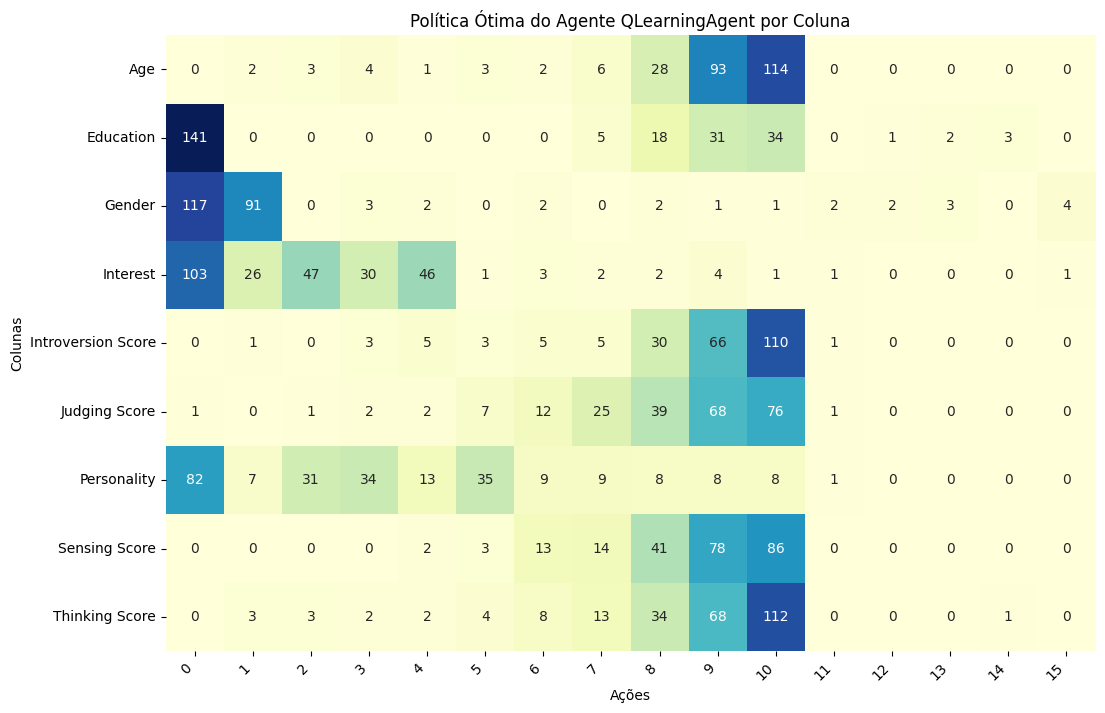

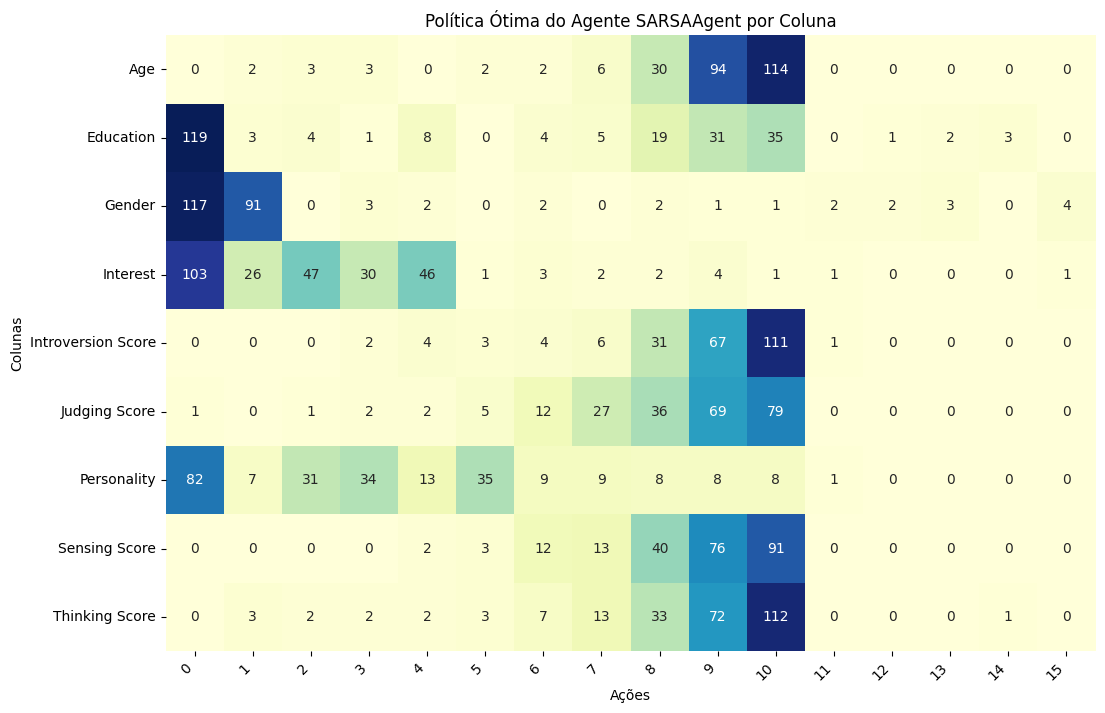


Preenchendo dados faltantes com o agente: QLearningAgent

### Avaliação da Imputação

**Erro Médio Absoluto (MAE) para Colunas Numéricas:**


,0
Age,0.523316
Education,0.008280
Introversion Score,0.116410
Sensing Score,0.057137
Thinking Score,0.125474
Judging Score,0.048714



**Taxa de Acerto para Colunas Categóricas:**
Coluna 'Gender': 0.94 (217/230)
Coluna 'Interest': 0.91 (242/267)
Coluna 'Personality': 0.86 (210/245)


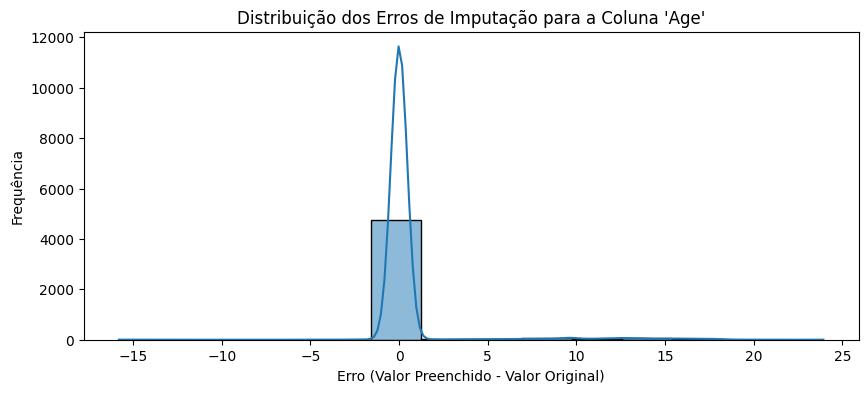

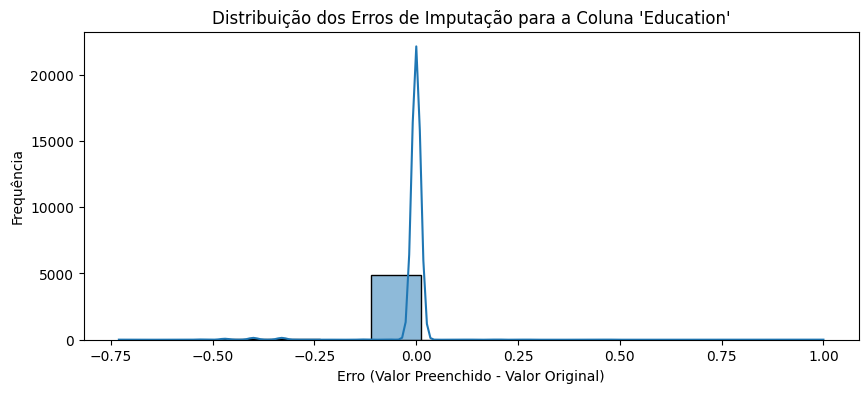

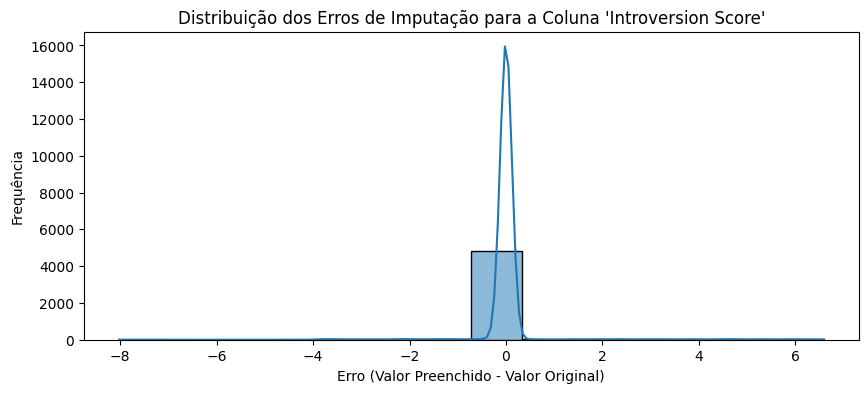

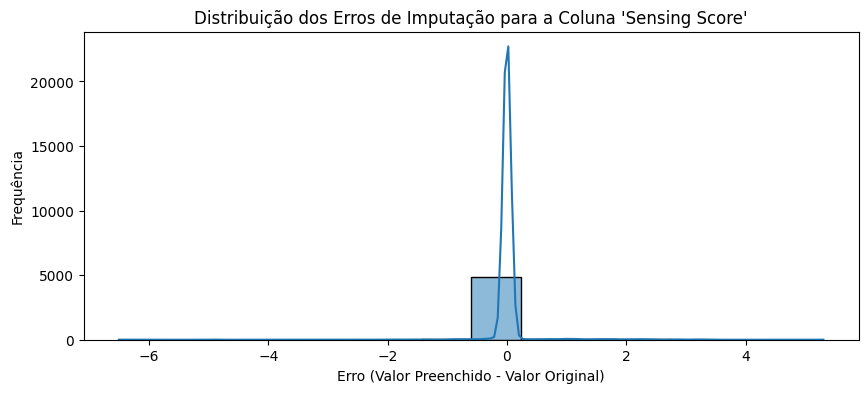

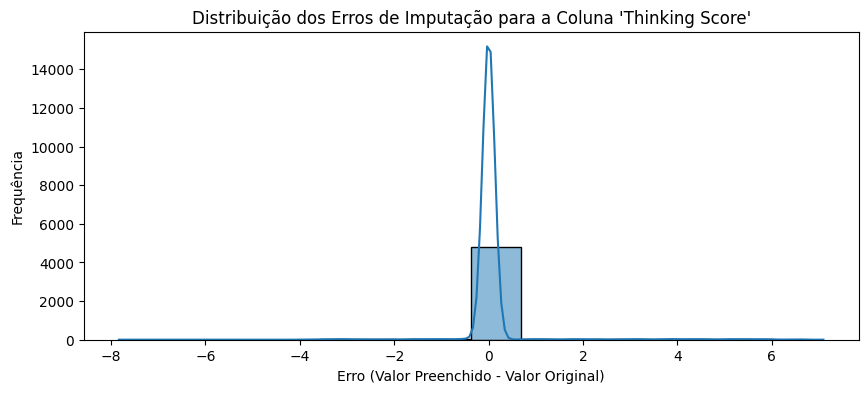

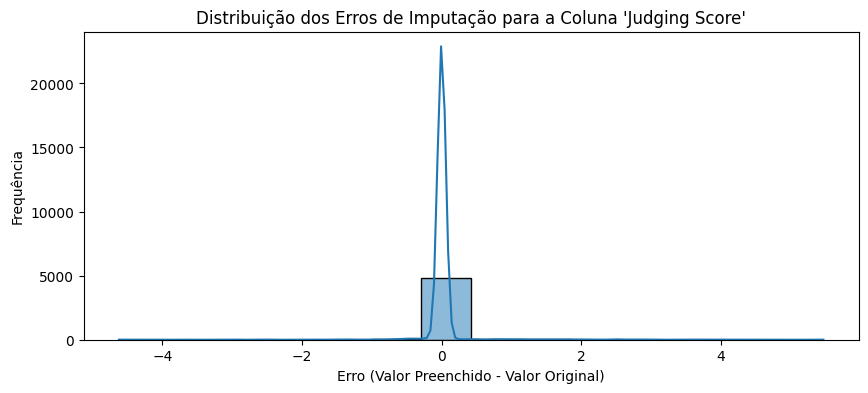


### Dataset Preenchido pelo Agente QLearningAgent (Primeiras 5 Linhas):


,Age,Gender,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
0,19.0,Male,0.0,9.47080,7.141434,6.03696,4.360278,Unknown,ENFP
1,36.6,Female,0.0,5.85392,6.160195,0.80552,4.221421,Sports,ESFP
2,21.0,Female,0.0,7.08615,3.388433,6.67000,5.127320,Unknown,ENFP
3,28.0,Male,0.0,2.01892,4.823624,7.30625,5.986550,Others,INTP
4,36.0,Female,1.0,9.91703,4.755080,5.31469,4.677213,Technology,ENFP


In [27]:
main_step3()